In [63]:
import json
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
import math
import cv2
import matplotlib.font_manager as fm
import pandas as pd
from tqdm import tqdm
import matplotlib

from PIL import Image
from collections import Counter
from pycocotools.coco import COCO

font_path = '/data/ephemeral/home/dataset/font/D2CODING-VER1.3.2-20180524.TTC'

if os.path.exists(font_path):
    fontprop = fm.FontProperties(fname=font_path)
else:
    fontprop = fm.FontProperties(family='san-serif')

# 경로 설정
source = '/data/ephemeral/home/dataset/train.json' # JSON 파일 경로
image_dir  = '/data/ephemeral/home/dataset/train' # 이미지 디렉토리 경로

# JSON 파일 불러오기
with open(source, 'r') as file:
    data = json.load(file)

# 클래스 컬러 설정
class_colors = {
    0: (255, 0, 0),
    1: (0, 0, 255),
    2: (255, 255, 0),
    3: (0, 255, 0),
    4: (128, 0, 128),
    5: (255, 192, 203),
    6: (255, 165, 0),
    7: (135, 206, 235),
    8: (128, 128, 128),
    9: (165, 42, 42)
}

normalized_class_colors = {class_id: (r/255, g/255, b/255) for class_id, (r, g, b) in class_colors.items()}

In [64]:
if 'categories' in data:
    categories = data['categories']
    id_to_name = {category['id']: category['name'] for category in categories}

    categories_id_name = {cat['id']: cat['name'] for cat in categories}
    

if 'annotations' in data:
    annotations = data['annotations']

if 'images' in data:
    images = data['images']
    images_id_img = {img['id']: img for img in data['images']}

### 전체 Train Data Image / Annotation / Category 갯수

In [65]:
print(f"Num of Images: {len(images)}")
print(f"Num of Annotations: {len(annotations)}")
print(f"Num of Categories: {len(categories)}")

Num of Images: 4883
Num of Annotations: 23144
Num of Categories: 10


### 카테고리 목록 확인

In [66]:
# 'categories' 배열에서 class_id와 class_name을 추출합니다.
print("Class ID, Name")

for id, name in categories_id_name.items():
    print(f"{id} {name}")

Class ID, Name
0 General trash
1 Paper
2 Paper pack
3 Metal
4 Glass
5 Plastic
6 Styrofoam
7 Plastic bag
8 Battery
9 Clothing


### Category ID별 갯수

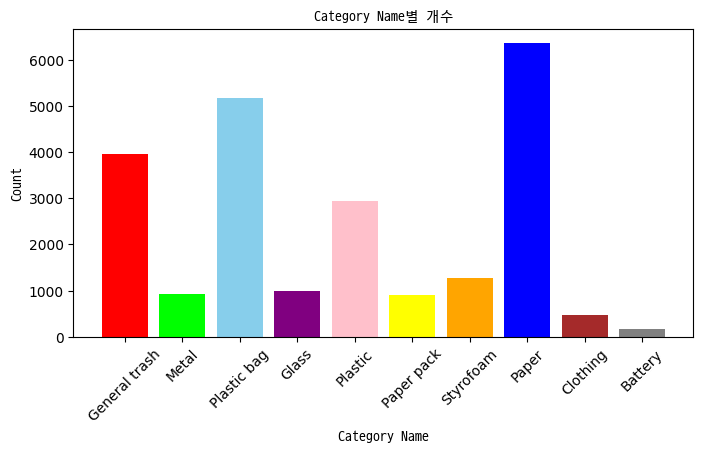

Category ID 0: 3966개
Category ID 3: 936개
Category ID 7: 5178개
Category ID 4: 982개
Category ID 5: 2943개
Category ID 2: 897개
Category ID 6: 1263개
Category ID 1: 6352개
Category ID 9: 468개
Category ID 8: 159개
총 category_id 개수: 23144개


In [67]:
if 'annotations' in data:
    # 그래프를 그리기 위한 데이터 준비
    category_ids = [item['category_id'] for item in annotations]
    category_id_count = Counter(category_ids)
    
    category_count = list(category_id_count.keys())
    counts = list(category_id_count.values())

    # 각 카테고리의 색상을 설정
    colors = [normalized_class_colors[cat_id] for cat_id in category_count]

    # 카테고리 이름으로 x축 라벨 설정
    category_names = [id_to_name[cat_id] for cat_id in category_count]
    # 막대 그래프 그리기
    plt.figure(figsize=(8, 4))
    plt.bar(category_names, counts, color=colors)
    plt.xlabel('Category Name', fontproperties=fontprop)
    plt.ylabel('Count', fontproperties=fontprop)
    plt.title('Category Name별 개수', fontproperties=fontprop)
    plt.xticks(rotation=45)  # x축 라벨 회전
    plt.show()


    # 결과를 출력합니다.
    for category_id, count in category_id_count.items():
        print(f"Category ID {category_id}: {count}개")

    # category_id의 총 개수를 계산합니다.
    total_count = sum(category_id_count.values())
    print(f"총 category_id 개수: {total_count}개")

### 이미지 크기 목록 확인

In [69]:
image_sizes = [(item['width'], item['height']) for item in images]

unique_image_sizes = set(image_sizes)

print("고유한 이미지 크기 목록:")
for width, height in unique_image_sizes:
    print(f"Width: {width}, Height: {height}")

고유한 이미지 크기 목록:
Width: 1024, Height: 1024


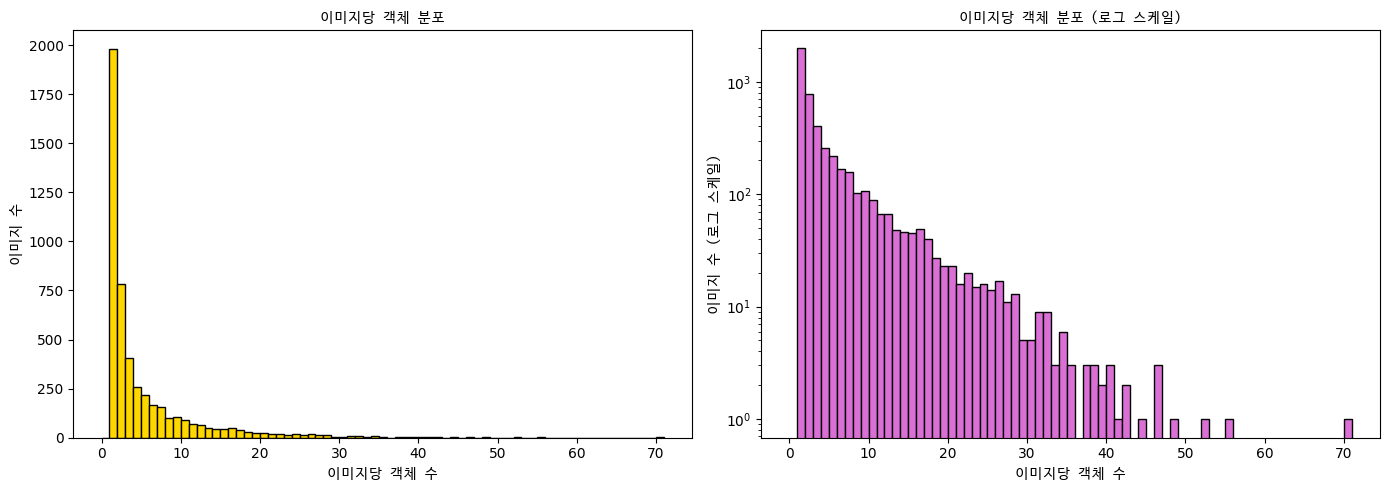

In [19]:
if 'annotations' in data:
    image_ids = [item['image_id'] for item in annotations]

    # image_id별로 객체 수를 셉니다.
    image_id_count = Counter(image_ids)

    # 객체 수 리스트
    object_counts = list(image_id_count.values())

    # 서브플롯 생성
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # 일반 막대 그래프
    axes[0].hist(object_counts, bins=range(0, max(object_counts) + 1), color='gold', edgecolor='black')
    axes[0].set_title('이미지당 객체 분포', fontproperties=fontprop)
    axes[0].set_xlabel('이미지당 객체 수', fontproperties=fontprop)
    axes[0].set_ylabel('이미지 수', fontproperties=fontprop)

    # 로그 스케일 막대 그래프
    axes[1].hist(object_counts, bins=range(0, max(object_counts) + 1), color='orchid', edgecolor='black')
    axes[1].set_yscale('log')
    axes[1].set_title('이미지당 객체 분포 (로그 스케일)', fontproperties=fontprop)
    axes[1].set_xlabel('이미지당 객체 수', fontproperties=fontprop)
    axes[1].set_ylabel('이미지 수 (로그 스케일)', fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

### 클래스별 이미지 면적 대비 바운딩 박스 면적 분포

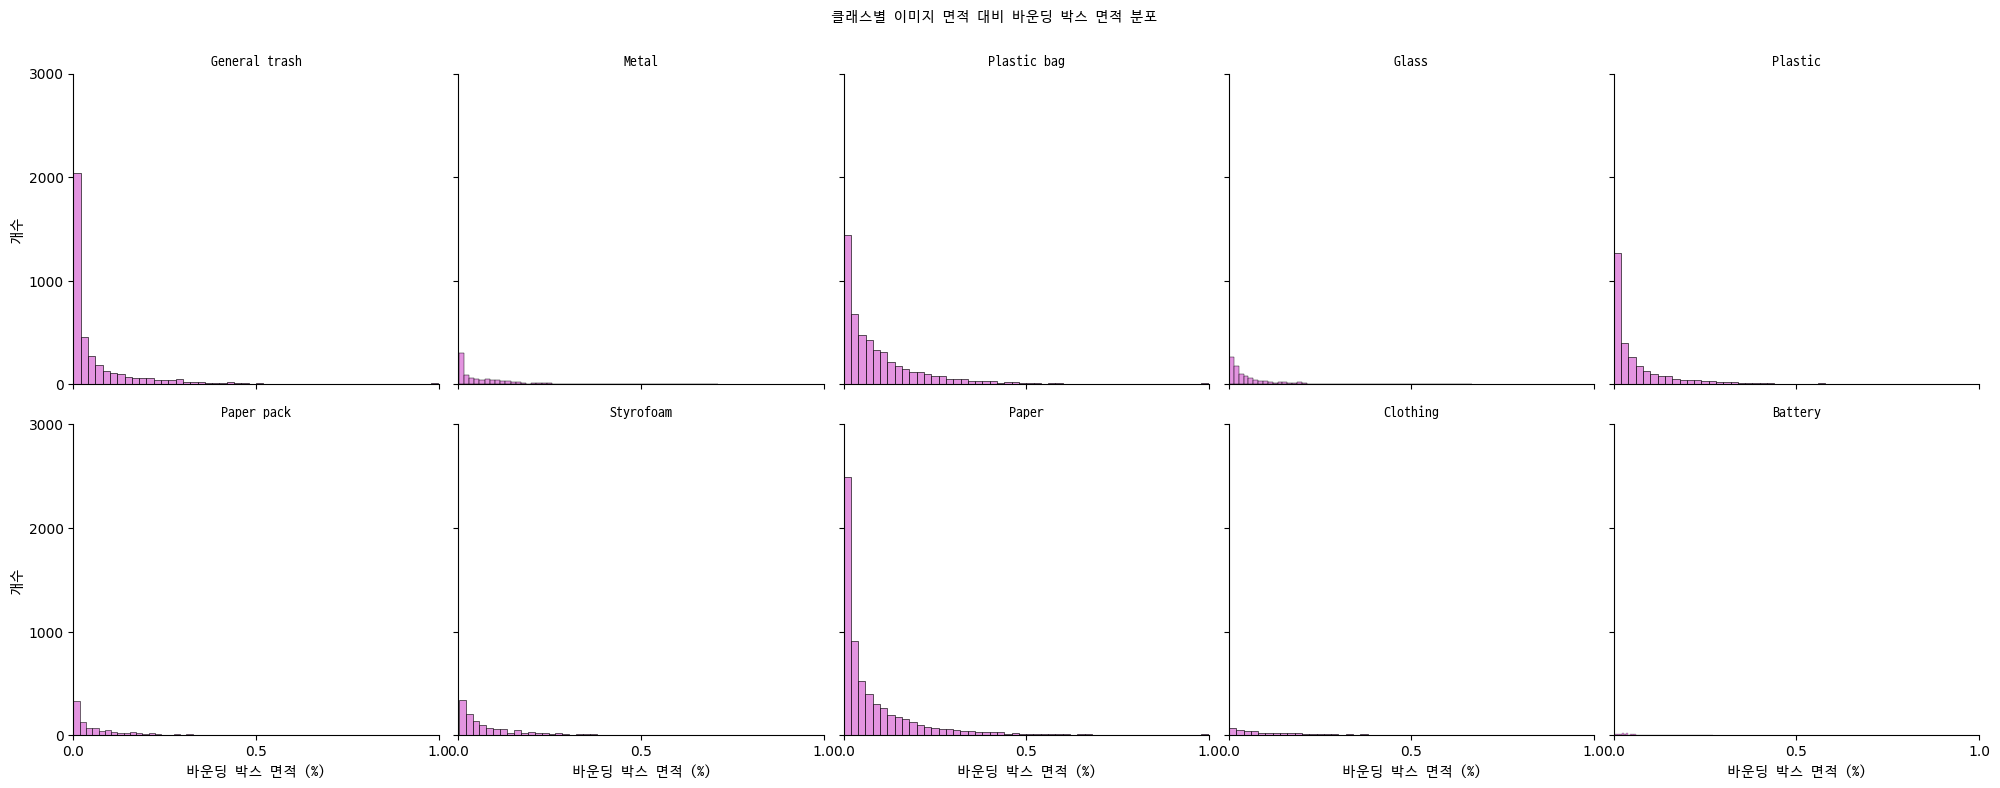

In [21]:
if 'annotations' in data and 'images' in data and 'categories' in data:

    # 바운딩 박스 면적 계산
    bbox_data = []
    for ann in annotations:
        image = images_id_img[ann['image_id']]
        image_area = image['width'] * image['height']
        bbox_area = ann['area']
        bbox_area_percentage = bbox_area / image_area
        category_name = categories_id_name.get(ann['category_id'], 'unknown')
        bbox_data.append({'Category': category_name, 'BBox Area %': bbox_area_percentage})

    # DataFrame 생성
    df = pd.DataFrame(bbox_data)

    # 시각화
    g = sns.FacetGrid(df, col='Category', col_wrap=5, height=4, sharex=True, sharey=True)
    g.map(sns.histplot, 'BBox Area %', bins=50, color='orchid')
    g.set_titles(col_template='{col_name}', fontproperties=fontprop)
    g.set_axis_labels('바운딩 박스 면적 (%)', '개수', fontproperties=fontprop)
    g.set(xlim=(0, 1), ylim=(0, 3000), xticks=[0, 0.5, 1], yticks=[0, 1000, 2000, 3000])
    plt.subplots_adjust(top=0.9)
    g.figure.suptitle('클래스별 이미지 면적 대비 바운딩 박스 면적 분포', fontproperties=fontprop)
    plt.show()

### 클래스별로 바운딩 박스의 가로 및 세로 크기 분포 확인

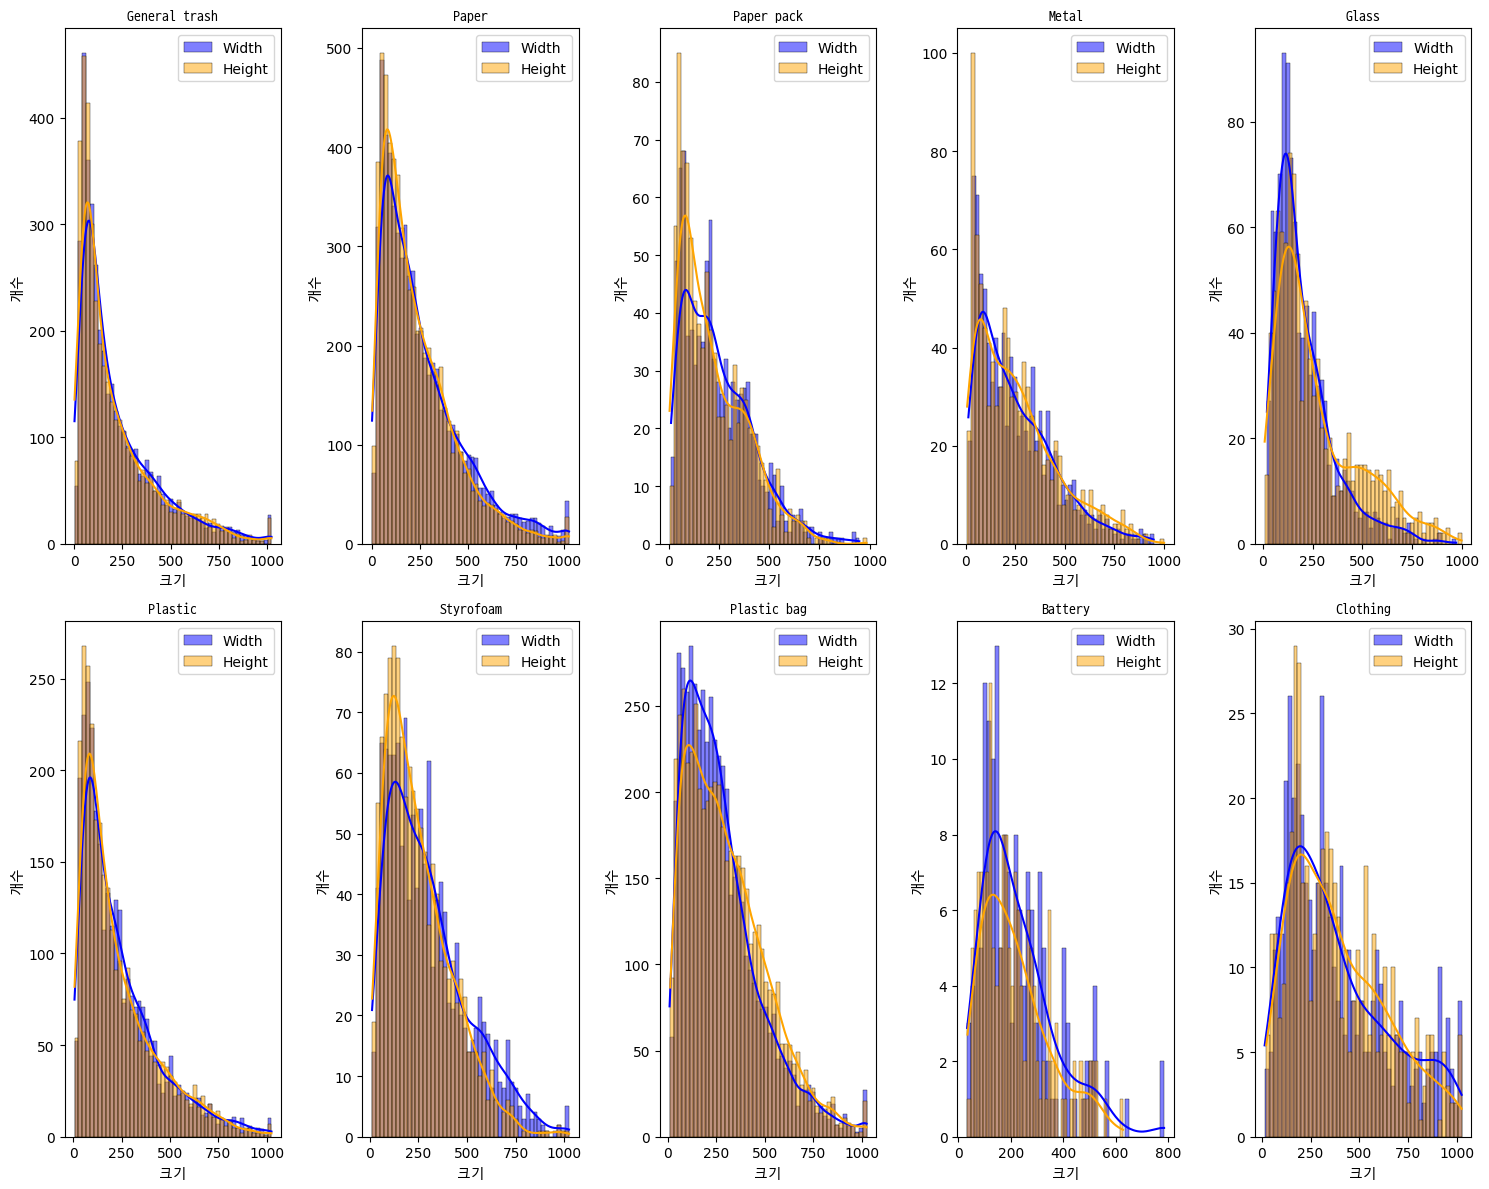

In [22]:
if 'annotations' in data and 'categories' in data:
    # 클래스 별 바운딩 박스의 가로 및 세로 크기 정보 추출
    class_bbox_widths = {category['id']: [] for category in categories}
    class_bbox_heights = {category['id']: [] for category in categories}

    for annotation in annotations:
        category_id = annotation['category_id']
        class_bbox_widths[category_id].append(annotation['bbox'][2])
        class_bbox_heights[category_id].append(annotation['bbox'][3])

    # 클래스별로 바운딩 박스의 가로 및 세로 크기 분포 확인
    plt.figure(figsize=(15, 12))

    class_names = {category['id']: category['name'] for category in categories}

    for i, (category_id, name) in enumerate(class_names.items(), start=1):
        plt.subplot(2, len(class_names)//2, i)
        sns.histplot(class_bbox_widths[category_id], bins=50, kde=True, color='blue', label='Width')
        sns.histplot(class_bbox_heights[category_id], bins=50, kde=True, color='orange', label='Height')
        plt.title(f'{name}', fontproperties=fontprop)
        plt.xlabel('크기', fontproperties=fontprop)
        plt.ylabel('개수', fontproperties=fontprop)
        plt.legend()

    plt.tight_layout()
    plt.show()
    

### bbox 크기 및 비율 분포 확인

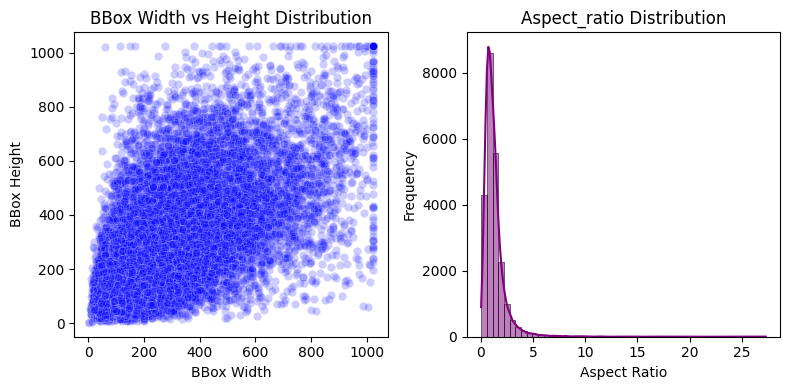

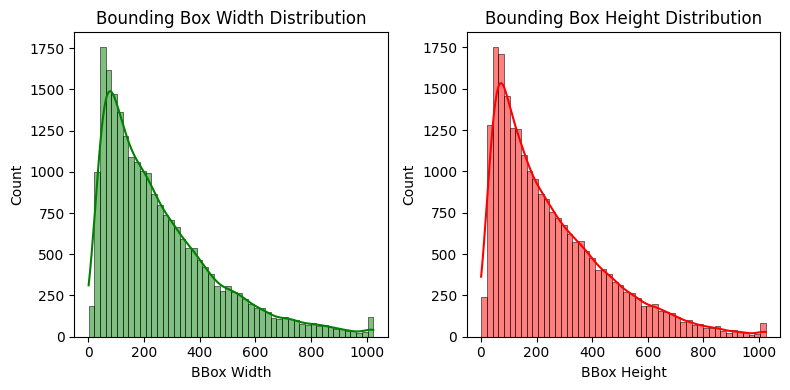

In [62]:
# 바운딩 박스의 너비와 높이 계산
bbox_data = []
ratios = []

size = 32
count = 0

for ann in annotations:
    bbox_width = ann['bbox'][2]
    bbox_height = ann['bbox'][3]
    
    ratios.append(bbox_width/bbox_height)

    if bbox_width <= size and bbox_height <= size:
        count += 1

    bbox_data.append({'Width': bbox_width, 'Height': bbox_height})

df = pd.DataFrame(bbox_data)


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Width', y='Height', data=df, color='b', alpha=0.2)
plt.xlabel('BBox Width')
plt.ylabel('BBox Height')
plt.title('BBox Width vs Height Distribution')

plt.subplot(1, 2, 2)
sns.histplot(ratios, bins=50, color='purple', kde=True)
plt.title('Aspect_ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# BBox의 너비와 높이 히스토그램
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['Width'], bins=50, color='g', kde=True)
plt.xlabel('BBox Width')
plt.ylabel('Count')
plt.title('Bounding Box Width Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Height'], bins=50, color='r', kde=True)
plt.xlabel('BBox Height')
plt.ylabel('Count')
plt.title('Bounding Box Height Distribution')

plt.tight_layout()
plt.show()

### 32×32 크기 이하 bbox 개수 확인

In [50]:
print(count)

840


### 이미지 내 바운딩 박스 배치 히트맵

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


100%|██████████| 23144/23144 [00:05<00:00, 3962.30it/s]


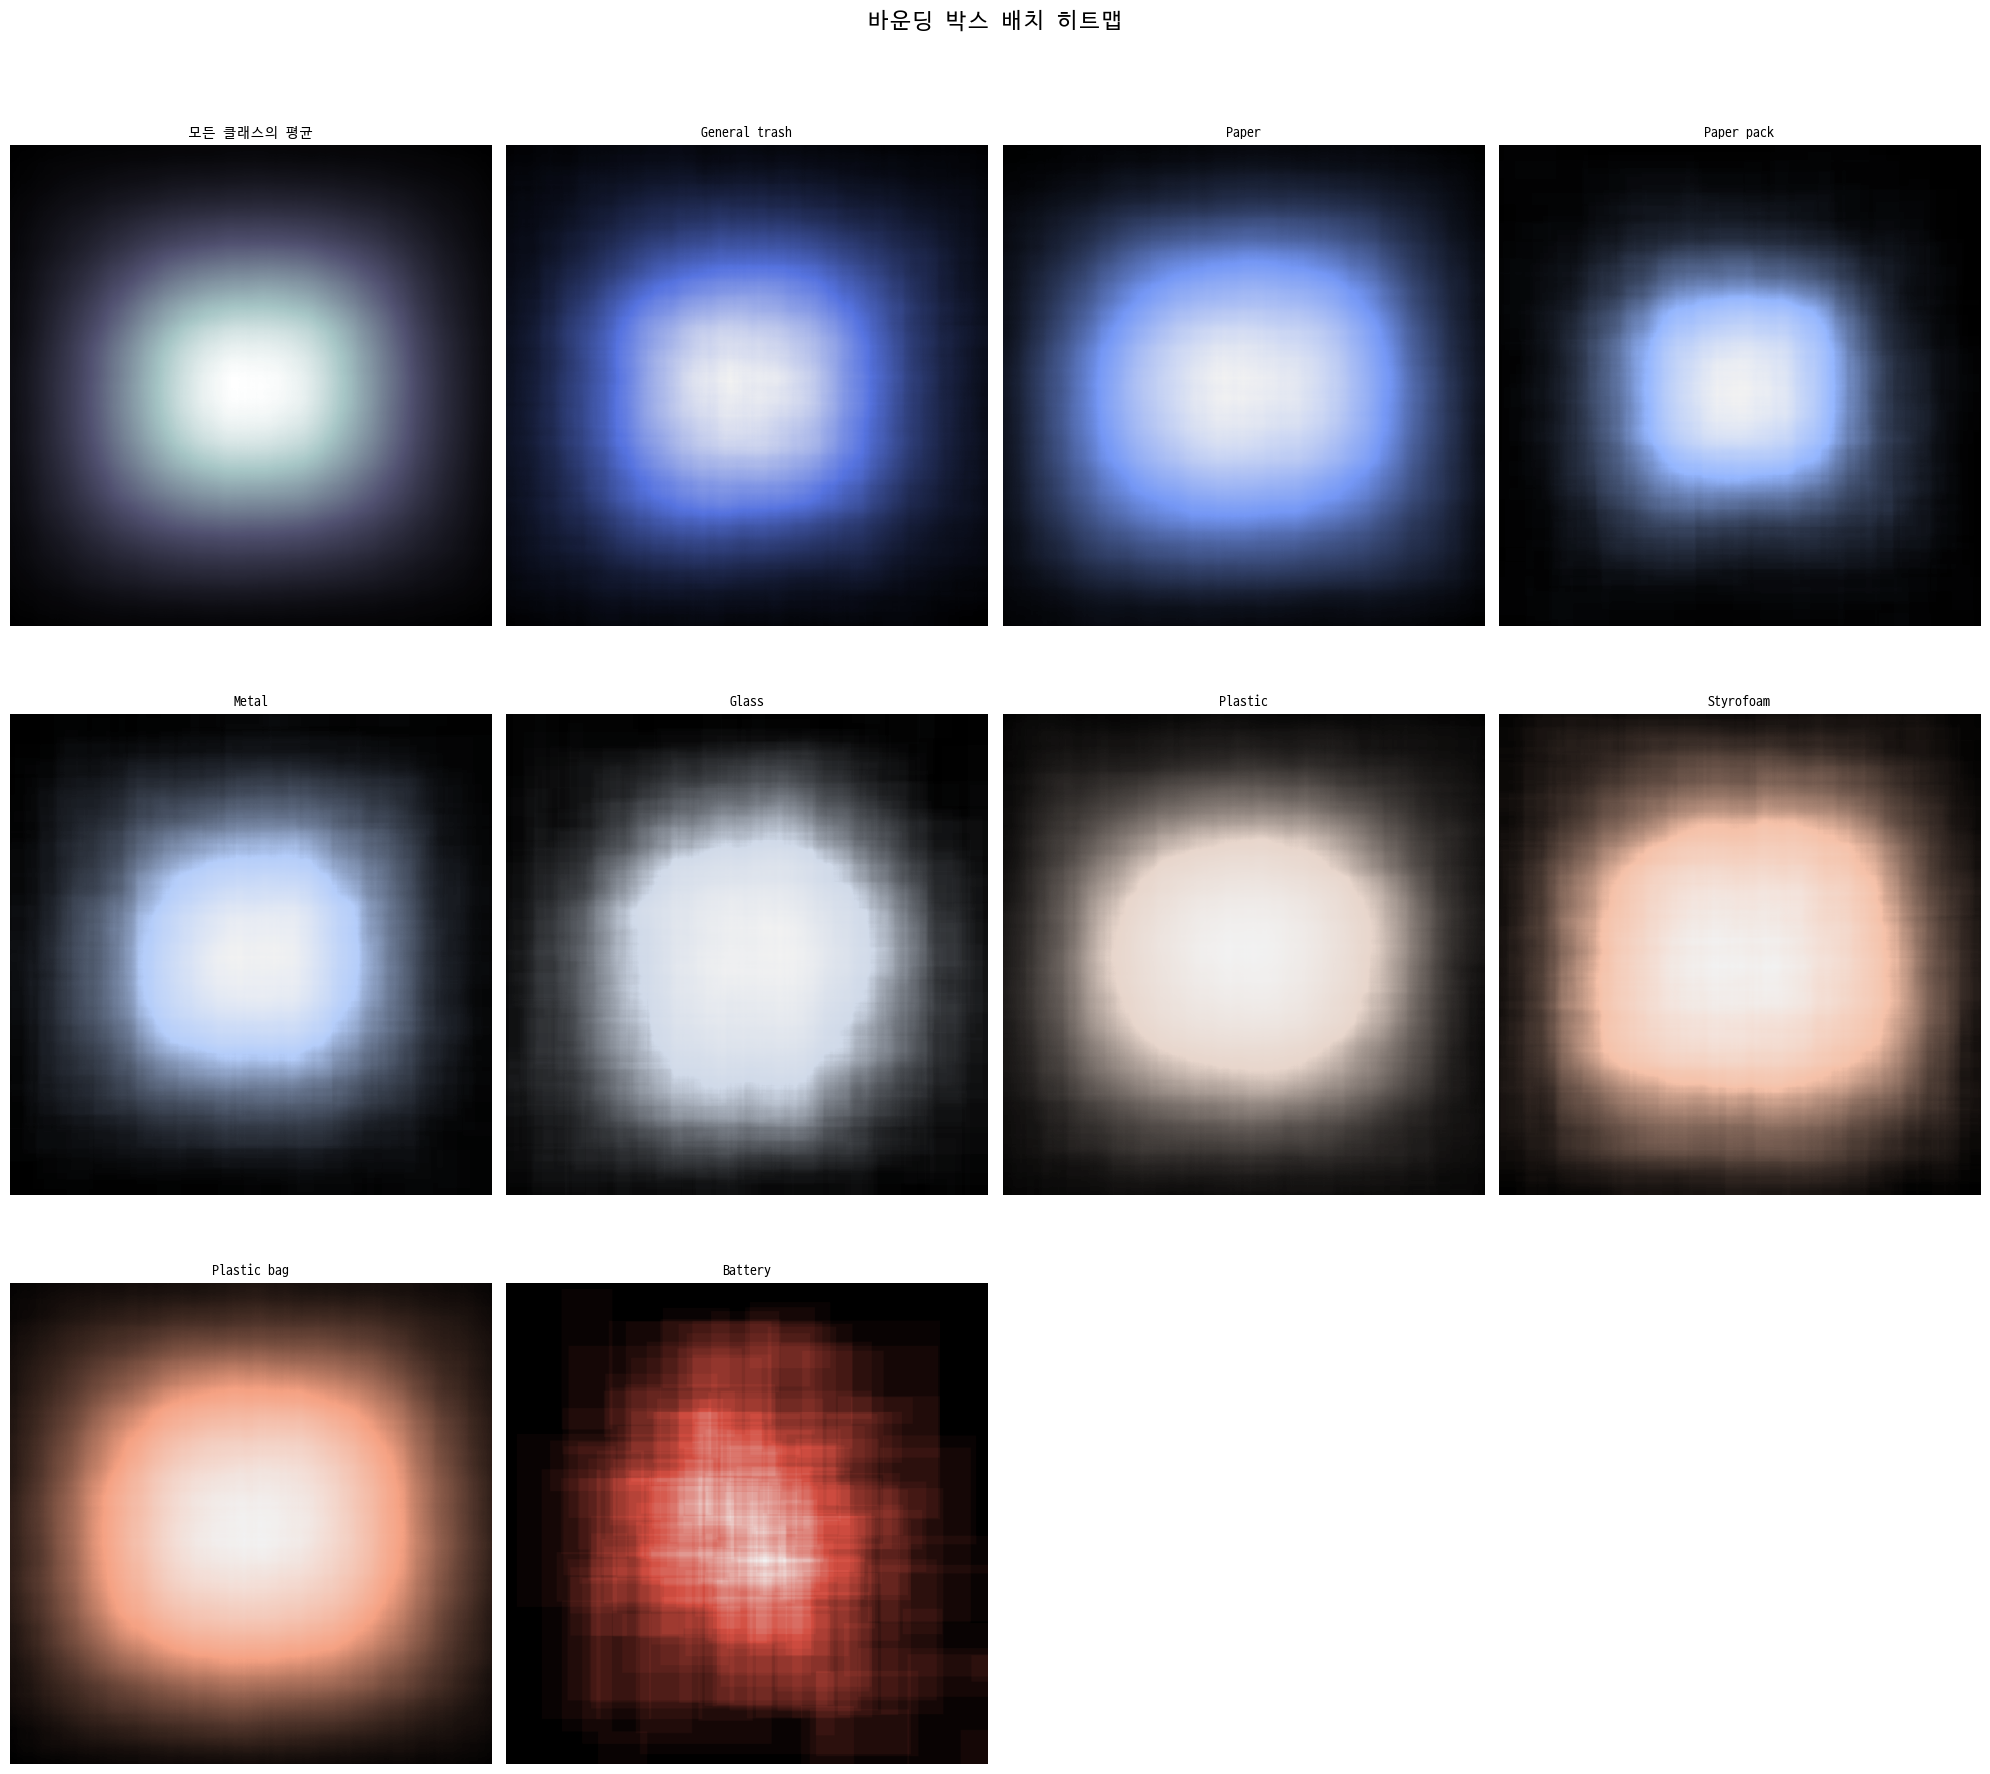

In [23]:
coco = COCO('/data/ephemeral/home/dataset/train.json')

train_df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass",
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
for image_id in coco.getImgIds():

    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)

    file_name = image_info['file_name']

    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max


bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values / 1024
bbox_df['x_max'] = train_df['x_max'].values / 1024
bbox_df['y_min'] = train_df['y_min'].values / 1024
bbox_df['y_max'] = train_df['y_max'].values / 1024
bbox_df['frac_x_min'] = train_df['x_min'].values / 1024
bbox_df['frac_x_max'] = train_df['x_max'].values / 1024
bbox_df['frac_y_min'] = train_df['y_min'].values / 1024
bbox_df['frac_y_max'] = train_df['y_max'].values / 1024

ave_src_img_height = 1024
ave_src_img_width = 1024

# DEFAULT
HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize
heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff
custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)],
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("coolwarm", 10))
]
custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(20,25))
plt.suptitle("바운딩 박스 배치 히트맵\n ", fontweight="bold", fontsize=16, fontproperties=fontprop)
for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"모든 클래스의 평균", fontweight="bold", fontproperties=fontprop)
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]}", fontweight="bold", fontproperties=fontprop)

    plt.axis(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()